In [18]:
import os
import json
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import metrics
import matplotlib
from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Concatenate, Flatten, MaxPooling1D
from keras.models import Model
from itertools import islice

Using TensorFlow backend.


In [2]:
json_file_dir = "G:\\Dev\\trees_gnps"
formula_occurences_path = "G:\\Dev\\fragment_occurences.csv"
saved_intensities_path = "G:\\Dev\\saved_intensities.csv"
formula_occurences = {}
num_formula = 0

In [8]:
with open(formula_occurences_path, 'r') as f:
    content = f.readlines()
    num_formula = len(content)
    
print(num_formula)

4616


In [9]:
filenames = [file[:-5] for file in os.listdir(json_file_dir)]

formula = [formula.split(",")[0] for formula in content]
intensities = pd.DataFrame(0.0, index = filenames, columns=formula, dtype=float)

for index, file in enumerate(filenames):
    filepath = os.path.join(json_file_dir, file + ".json")
    print(index)
    with open(filepath, 'r') as f:
        data = json.load(f)

        for fragment in data['fragments']:
            if fragment["molecularFormula"] in formula and "intensity" in fragment:
                intensities.at[file, fragment["molecularFormula"]] = float(fragment["intensity"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102


3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743


5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382


In [10]:
intensities.to_csv(saved_intensities_path, encoding='utf-8', index=False)

In [29]:
saved_intensities = pd.read_csv(saved_intensities_path, sep=",")
saved_intensities.index = filenames
print(saved_intensities)

                            C9H6          C8H8          C8H6         C9H8  \
CCMSLIB00000001548  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001549  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001550  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001555  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001563  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001565  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001566  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001568  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001569  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001570  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001572  0.000000e+00  0.000000e+00  0.000000e+00     0.000000   
CCMSLIB00000001574  0.000000e+00  0.000000e+00  2.921284e+02     0.000000   

In [30]:
# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_fingerprints_master(path, number_of_rows=0):
    BITS = 307  # Total number of bits in fingerprint

    #fp_all = np.loadtxt(fingerprints_path, dtype="U25") # Get master file as numpy array of Strings
    
    # fp_all = np.loadtxt(path, dtype="U25", skiprows=1) # skip first row of headers
    
    fp_all = np.loadtxt(path, dtype="U25", skiprows=number_of_rows) # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0]) # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        fingerprints.at[row[0], int(row[1])] = int(row[2])

    # Convert populated dataframe into a numpy array for use as output by neural networks.
    return fingerprints

In [36]:
# Import Sotchastic Gradient Descent object from Keras to allow for tweaking its learning rate.
from keras.optimizers import SGD

# A simplified spectrum-fingeprrint encoder.
# Structure: (Input)1000-500-200-307(Output)
def simplified_fingerprint_model(x_train_spectra, x_train_fingerprints, epochs=100, lr=0.5):
    # Create input based on the provided x_train data structure.
    input_layer = Input(shape=(x_train_spectra.shape[1],))
    # Since output is not the same as input, we obtain its shape separately.
    output_dims = x_train_fingerprints.shape[1]
    
    # Create the encoding layers using functional API.
    l = input_layer
    l = Dense(500, activation='relu')(l)
    
    # Linear activation ensures that values can be negative (necessary for sigmoid to function)
    l = Dense(200, activation='linear')(l)
    
    # Save reference to latent space
    latent_space = l
    
    # Sigmoid activation to get outputs between 0 and 1. This is done because the output fingerprint is a set of bits (0 or 1).
    l2 = Dense(output_dims, activation='sigmoid')(l)
    
    #Reference for output layer
    out_layer = l2

    auto_model = Model(input=input_layer, output=out_layer)
    
    # Set SGD learning rate provided as parameter and compile model with MSE as loss function.
    sgd = SGD(lr=lr)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    # Train the model for the specified number of epochs, using the specified validation fraction.
    autoencoder_train = auto_model.fit(x_train_spectra, x_train_fingerprints, shuffle=False, validation_split = 0.1, epochs=epochs)
    
    # Loss Plots
    plot_loss(autoencoder_train, epochs)
    
    return auto_model # Return model, now trained

In [32]:
# This function takes as input a trained neural network model and extracts its history variable.
# It then uses it to graph the model's loss and validation loss over the training epochs
# The epochs paramter is used for plotting the x axis.
def plot_loss(fitted_model, epochs):
    # Extract loss values for the training and validation sets.
    loss = fitted_model.history['loss']
    val_loss = fitted_model.history['val_loss']
    # Create x axis variables.
    epochs_label = epochs
    epochs = range(epochs)

    #Plot both losses.
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss,'r', label='Validation loss')
    plt.title('Training and Validation Loss for ' + str(epochs_label) + ' epochs')
    plt.legend()
    plt.show()

# Takes a trained autoencoder model and input data. Uses the model to predit on the provided data
# It then plots the input data vs. the model's prediction for a specified sample in the data.
def plot_input_output(auto_model, data, sample=0):
    # set font size
    matplotlib.rcParams.update({'font.size': 14})
    # Use model to make predictions for the provided input data.
    decoded_data = auto_model.predict(data)
    # Create plot
    fig, ax = plt.subplots()
    for i, d in enumerate(data[sample]):
        # For each datapoint in the specified sample, plot a vertical line equal to its intensity value.
        if d>0.1:
            ax.plot([i,i],[0, d], color='g')
        # Do the same for the corresponding prediction but using negative values, to create a "mirror" plot
        if decoded_data[sample][i]>0.1:
            ax.plot([i,i],[0,-decoded_data[sample][i]], color='r')
    # Plot invisible line on far end of spectrum so all 1000 mass bins are shown even if absent.
    ax.plot([999,999], [0,0])
    ax.set_xlabel("Mass Bin(Da)")
    ax.set_ylabel("Relative Abundance")
    plt.show()
    
# Takes actual and predicted fingerprint bit sets and plots a representative graph
# Similar to the fragment spectrum plotting.
def plot_fingerprint_output(actual, predicted, sample=0):
    fig, ax = plt.subplots()
    for i, d in enumerate(actual[sample]):
        # For each substructure in fingerprint, plot a vertical line if it is present.
        ax.plot([i,i],[0,d], color='g')
        # DO the same for prediction, using the predicted probability of the susbtructure's presence.
        ax.plot([i,i],[0, -predicted[sample][i]], color = 'r')
    # Plot invisible line on far end of fingerprint.
    ax.plot([307,307], [0,0])
    ax.set_xlabel("Substructure (Index in CDK)")
    ax.set_ylabel("Probability of Presence")
    plt.show()

    
# Takes a actual and predicted fingerprint values and computes the area under the Roc curve for each substructure.
# For each subtructure, also calculates AUC when the actual values are scrambled.
# Return two numpy arrays: one containing AUC metrics for all susbtructures, one containing each permutation's
# AUC scores for each susbtructure.
def compute_auc(bits, true, pred, permutations=500):
    num_permutations = permutations  # Number of permutations to compute AUC scores for. 
    
    # Create structured array to hold statistics for each fingerprint.
    dtype = [('fp_id', int),('nonzeros', int), ('auc', float), ('auc_percent', float)]
    mol_stats = np.zeros((bits,), dtype=dtype)
    # Create array to hold permutation AUC scores for plotting.
    perm_scores = np.zeros((bits, num_permutations))
    val_start_index = 0
    for fp_id in range(true.shape[1]): # For every substructure      
        nonzero_vals = np.count_nonzero(true[val_start_index:, fp_id]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[val_start_index:, fp_id].size:  # If there are no 1s or no 0s, can't compute.
            # Compute actual AUC score using only the validation fraction of the dataset.
            fp_true = true[val_start_index:, fp_id]
            fp_pred = pred[val_start_index:, fp_id]
            score = metrics.roc_auc_score(fp_true, fp_pred)

            # Compute AUC scores for permutations and compare to actual.
            counter = 0         
            for i in range(num_permutations):
                permutation = np.random.permutation(fp_true)
                perm_score = metrics.roc_auc_score(permutation, fp_pred)
                perm_scores[fp_id, i] = perm_score
                # Count how many permutations have a higer AUC score than actual data.
                if perm_score >= score:
                    counter = counter + 1
            # Calculate % of scrambled values with higher AUC score than actual AUC
            percentage = (counter/num_permutations)*100
        # Update structured array with data or non values if no AUC could be calculated.
            mol_stats[fp_id] = fp_id, nonzero_vals, score, percentage
        else:
            mol_stats[fp_id] = (fp_id, nonzero_vals, 0, 100)
        
    # Permutations take a while, print statement to say when finished.
    print("Done")
    return mol_stats, perm_scores

In [33]:
fingerprints_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Fingerprints.txt"

In [34]:
fingerprints = load_fingerprints_master(fingerprints_path)

print(fingerprints)

                    0    1    2    3    4    5    6    7    8    9   ...   \
CCMSLIB00000001548    1    1    1    0    0    0    0    0    0    0 ...    
CCMSLIB00000001549    1    1    0    0    1    0    0    0    0    0 ...    
CCMSLIB00000001550    0    0    0    0    1    0    0    0    0    0 ...    
CCMSLIB00000001555    1    1    1    0    0    0    0    1    0    0 ...    
CCMSLIB00000001563    1    1    1    0    0    0    0    0    0    0 ...    
CCMSLIB00000001565    1    1    1    0    1    1    0    0    0    0 ...    
CCMSLIB00000001566    1    1    1    0    0    0    0    0    0    0 ...    
CCMSLIB00000001568    1    1    1    0    0    0    0    0    0    0 ...    
CCMSLIB00000001569    1    1    1    0    1    1    0    0    0    0 ...    
CCMSLIB00000001570    1    1    1    0    0    0    0    0    0    0 ...    
CCMSLIB00000001572    1    1    1    0    0    0    0    0    0    0 ...    
CCMSLIB00000001574    1    1    0    0    0    0    0    0    0    0 ...    

C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 5193 samples, validate on 577 samples
Epoch 1/100
5193/5193 [==============================] - 4s 798us/step - loss: 0.0972 - val_loss: 0.0506
Epoch 2/100
5193/5193 [==============================] - 4s 704us/step - loss: 0.0384 - val_loss: 0.0360
Epoch 3/100
5193/5193 [==============================] - 4s 693us/step - loss: 0.0314 - val_loss: 0.0306
Epoch 4/100
5193/5193 [==============================] - 4s 722us/step - loss: 0.0287 - val_loss: 0.0283
Epoch 5/100
5193/5193 [==============================] - 4s 729us/step - loss: 0.0272 - val_loss: 0.0272
Epoch 6/100
5193/5193 [==============================] - 4s 729us/step - loss: 0.0262 - val_loss: 0.0264
Epoch 7/100
5193/5193 [==============================] - 4s 718us/step - loss: 0.0255 - val_loss: 0.0258
Epoch 8/100
5193/5193 [==============================] - 4s 717us/step - loss: 0.0249 - val_loss: 0.0255
Epoch 9/100
5193/5193 [==============================] - 4s 717us/step - loss: 0.0244 - val_loss: 0.0251
Epoch 10

Epoch 78/100
5193/5193 [==============================] - 4s 713us/step - loss: 0.0126 - val_loss: 0.0203
Epoch 79/100
5193/5193 [==============================] - 4s 707us/step - loss: 0.0126 - val_loss: 0.0203
Epoch 80/100
5193/5193 [==============================] - 4s 723us/step - loss: 0.0125 - val_loss: 0.0202
Epoch 81/100
5193/5193 [==============================] - 4s 713us/step - loss: 0.0124 - val_loss: 0.0202
Epoch 82/100
5193/5193 [==============================] - 4s 723us/step - loss: 0.0123 - val_loss: 0.0202
Epoch 83/100
5193/5193 [==============================] - 4s 719us/step - loss: 0.0122 - val_loss: 0.0202
Epoch 84/100
5193/5193 [==============================] - 4s 711us/step - loss: 0.0121 - val_loss: 0.0202
Epoch 85/100
5193/5193 [==============================] - 4s 714us/step - loss: 0.0120 - val_loss: 0.0202
Epoch 86/100
5193/5193 [==============================] - 4s 722us/step - loss: 0.0120 - val_loss: 0.0202
Epoch 87/100
5193/5193 [======================

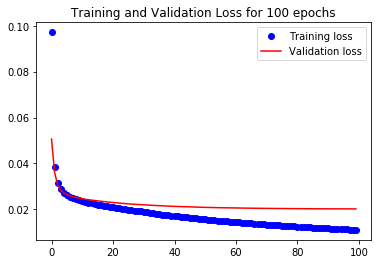

In [43]:
# Example of how to run a fingerprint encoder

epochs = 100
x_train_spectra = np.log(saved_intensities.values+1)
x_train_fingerprints = fingerprints.values

enc = simplified_fingerprint_model(x_train_spectra, x_train_fingerprints, epochs=epochs)

In [44]:
actual = x_train_fingerprints
predicted = enc.predict(x_train_spectra)

In [47]:
baseline_stats, baseline_perm_scores = compute_auc(307, actual, predicted)

Done


In [ ]:
evaluate(baseline_stats, baseline_perm_scores, baseline_stats, baseline_perm_scores)